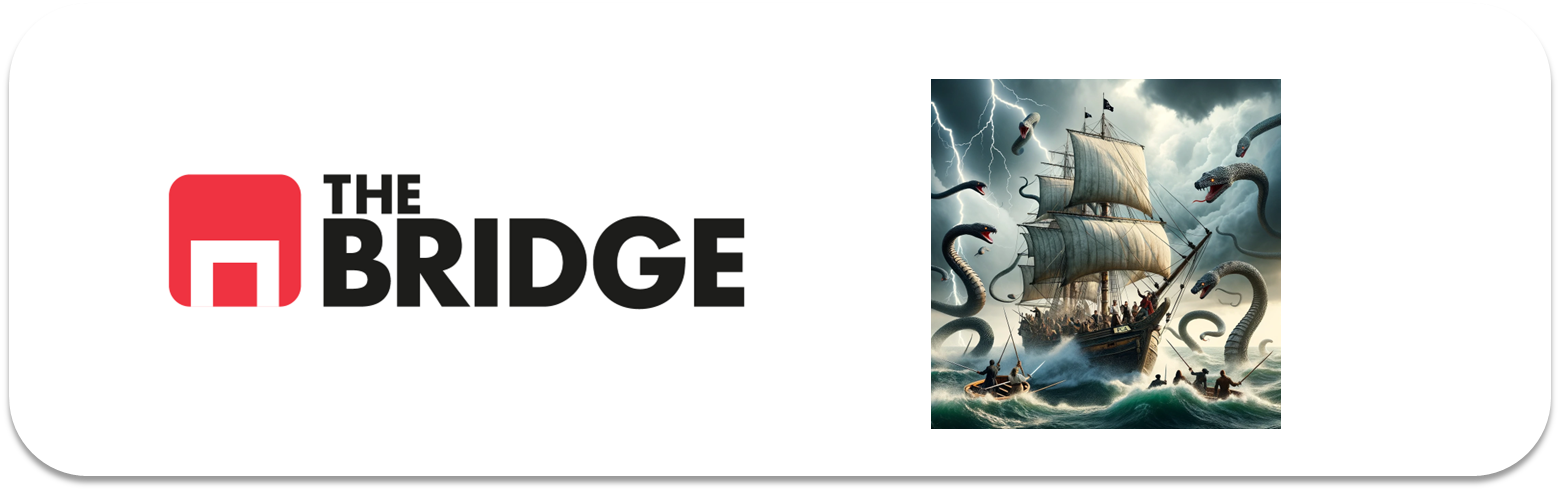

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [19]:
import bootcampviztools as viz

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE, SequentialFeatureSelector
from lightgbm import LGBMClassifier
from sklearn.metrics import mutual_info_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from scipy import stats
from xgboost import XGBClassifier

#import warnings library
import warnings

# ignore all warnings
warnings.filterwarnings('ignore')

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


In [20]:
df = pd.read_csv("./data/credit_npo.csv")
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

Hay nulos en las variables "MonthlyIncome" y "NumberOfDependents". Eliminamos las filas con nulos

In [22]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11816 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      11816 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11816 non-null  float64
 2   age                                   11816 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11816 non-null  int64  
 4   DebtRatio                             11816 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11816 non-null  int64  
 7   NumberOfTimes90DaysLate               11816 non-null  int64  
 8   NumberRealEstateLoansOrLines          11816 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11816 non-null  int64  
 10  NumberOfDependents                    11816 non-null  float64
dtypes: float64(4), int64

Rescato la clasificación de variables realizada en una práctica anterior:
* SeriousDlqin2yrs: Indica si la persona se cataloga como morosa en los últimos 2 años. Tipo: Categórica (Binaria)
* RevolvingUtilizationOfUnsecuredLines: Porcentaje de saldo total de las tarjetas de crédito y las líneas de crédito personales. Tipo: Numérica continua
* age: Edad del prestatario en años. Tipo: Numérica continua
* NumberOfTime30-59DaysPastDueNotWorse: Número de veces que el prestatario ha estado en impago de 30 a 59 días en los últimos 2 años. Tipo: Numérica discreta
* DebtRatio: Porcentaje de pagos mensuales de deudas. Tipo: Numérica continua
* MonthlyIncome: Ingresos mensuales. Tipo: Numérica continua
* NumberOfOpenCreditLinesAndLoans: Número de préstamos abiertos y líneas de crédito. Tipo: Numérica discreta
* NumberOfTimes90DaysLate: Número de veces que el prestatario ha estado 90 días o más en impago. Tipo: Numérica discreta
* NumberRealEstateLoansOrLines: Número de préstamos con garantía hipotecaria. Tipo: Numérica discreta
* NumberOfTime60-89DaysPastDueNotWorse: Número de veces que el prestatario ha estado entre 60 y 89 días en impago en los últimos 2 años. Tipo: Numérica discreta
* NumberOfDependents: Número de personas a cargo en la familia. Tipo: Numérica discreta

Definimos `SeriousDlqin2yrs` como la variable *target* y visualizamos su distribución

In [23]:
target = "SeriousDlqin2yrs"

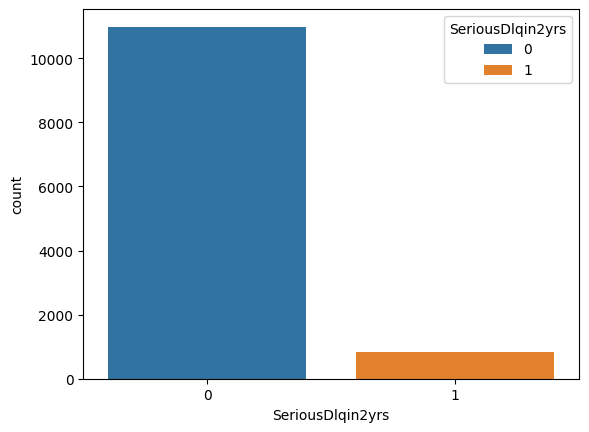

In [24]:
sns.countplot(df, x = target, hue = target);

In [25]:
df[target].value_counts(normalize=True)

SeriousDlqin2yrs
0    0.929756
1    0.070244
Name: proportion, dtype: float64

El dataset está muy desbalanceado hacia la clase 0 (no tendrá problemas de impago en los próximos 2 años), con un 93% frente a un 7% de la clase 1 (si tendrá problemas de impago en los próximos 2 años). Para los modelos habrá que fijar un hiperparámetro que tenga en cuenta ésta situación

Realizamos la división en train y test con la relación 80/20

In [26]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

Convertimos las variables `NumberOf...` a categóricas tanto en train como en test

**Conversión de "NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"**

Asignamos el valor 0 para indicar que nunca ha tenido impagos (en los periodos que indica cada variable) y asignamos el valor 1 para indicar que si los ha tenido

In [27]:
#Inicializamos con un valor para la nueva columna
train_set["NumberOfTime30-59DaysPastDueNotWorse_agrupado"] = 0
test_set["NumberOfTime30-59DaysPastDueNotWorse_agrupado"] = 0

#Sustituimos el valor en el caso de que se cumpla la condición
train_set.loc[train_set["NumberOfTime30-59DaysPastDueNotWorse"]>0,"NumberOfTime30-59DaysPastDueNotWorse_agrupado"] = 1
test_set.loc[test_set["NumberOfTime30-59DaysPastDueNotWorse"]>0,"NumberOfTime30-59DaysPastDueNotWorse_agrupado"] = 1

#Eliminamos la columna inicial
train_set.drop(columns=["NumberOfTime30-59DaysPastDueNotWorse"], inplace=True)
test_set.drop(columns=["NumberOfTime30-59DaysPastDueNotWorse"], inplace=True)

#Visualizamos en train
train_set["NumberOfTime30-59DaysPastDueNotWorse_agrupado"].value_counts()

NumberOfTime30-59DaysPastDueNotWorse_agrupado
0    7856
1    1596
Name: count, dtype: int64

In [28]:
#Inicializamos con un valor para la nueva columna
train_set["NumberOfTimes90DaysLate_agrupado"] = 0
test_set["NumberOfTimes90DaysLate_agrupado"] = 0

#Sustituimos el valor en el caso de que se cumpla la condición
train_set.loc[train_set["NumberOfTimes90DaysLate"]>0,"NumberOfTimes90DaysLate_agrupado"] = 1
test_set.loc[test_set["NumberOfTimes90DaysLate"]>0,"NumberOfTimes90DaysLate_agrupado"] = 1

#Eliminamos la columna inicial
train_set.drop(columns=["NumberOfTimes90DaysLate"], inplace=True)
test_set.drop(columns=["NumberOfTimes90DaysLate"], inplace=True)

#Visualizamos en train
train_set["NumberOfTimes90DaysLate_agrupado"].value_counts()

NumberOfTimes90DaysLate_agrupado
0    8919
1     533
Name: count, dtype: int64

In [29]:
#Inicializamos con un valor para la nueva columna
train_set["NumberOfTime60-89DaysPastDueNotWorse_agrupado"] = 0
test_set["NumberOfTime60-89DaysPastDueNotWorse_agrupado"] = 0

#Sustituimos el valor en el caso de que se cumpla la condición
train_set.loc[train_set["NumberOfTime60-89DaysPastDueNotWorse"]>0,"NumberOfTime60-89DaysPastDueNotWorse_agrupado"] = 1
test_set.loc[test_set["NumberOfTime60-89DaysPastDueNotWorse"]>0,"NumberOfTime60-89DaysPastDueNotWorse_agrupado"] = 1

#Eliminamos la columna inicial
train_set.drop(columns=["NumberOfTime60-89DaysPastDueNotWorse"], inplace=True)
test_set.drop(columns=["NumberOfTime60-89DaysPastDueNotWorse"], inplace=True)

#Visualizamos en train
train_set["NumberOfTime60-89DaysPastDueNotWorse_agrupado"].value_counts()

NumberOfTime60-89DaysPastDueNotWorse_agrupado
0    8953
1     499
Name: count, dtype: int64

**Conversión de "NumberRealEstateLoansOrLines"**

Asignamos el valor 0 para indicar que tiene 0 o 1 préstamo con garantía hipotecaria y asignamos el valor 1 para indicar que tiene más de 1 préstamo con garantía hipotecaria

In [30]:
#Inicializamos con un valor para la nueva columna
train_set["NumberRealEstateLoansOrLines_agrupado"] = 0
test_set["NumberRealEstateLoansOrLines_agrupado"] = 0

#Sustituimos el valor en el caso de que se cumpla la condición
train_set.loc[train_set["NumberRealEstateLoansOrLines"]>1,"NumberRealEstateLoansOrLines_agrupado"] = 1
test_set.loc[test_set["NumberRealEstateLoansOrLines"]>1,"NumberRealEstateLoansOrLines_agrupado"] = 1

#Eliminamos la columna inicial
train_set.drop(columns=["NumberRealEstateLoansOrLines"], inplace=True)
test_set.drop(columns=["NumberRealEstateLoansOrLines"], inplace=True)

#Visualizamos en train
train_set["NumberRealEstateLoansOrLines_agrupado"].value_counts()

NumberRealEstateLoansOrLines_agrupado
0    6690
1    2762
Name: count, dtype: int64

**Conversión de "NumberOfDependents"**

Asignamos el valor 0 para indicar que no tiene personas a cargo y asignamos el valor 1 para indicar que tiene 1 o más personas a cargo

In [31]:
#Inicializamos con un valor para la nueva columna
train_set["NumberOfDependents_agrupado"] = 0
test_set["NumberOfDependents_agrupado"] = 0

#Sustituimos el valor en el caso de que se cumpla la condición
train_set.loc[train_set["NumberOfDependents"]>0,"NumberOfDependents_agrupado"] = 1
test_set.loc[test_set["NumberOfDependents"]>0,"NumberOfDependents_agrupado"] = 1

#Eliminamos la columna inicial
train_set.drop(columns=["NumberOfDependents"], inplace=True)
test_set.drop(columns=["NumberOfDependents"], inplace=True)

#Visualizamos en train
train_set["NumberOfDependents_agrupado"].value_counts()

NumberOfDependents_agrupado
0    5125
1    4327
Name: count, dtype: int64

## **Proceso EDA**

### **1. Selección mediante análisis visual y filtrado**

### 1. Variables numéricas

Realizamos el análisis bivariante de las variables numéricas con el *target*

In [32]:
columnas_numericas = [columna for columna in train_set if "_agrupado" not in columna and columna != target]
columnas_numericas

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans']

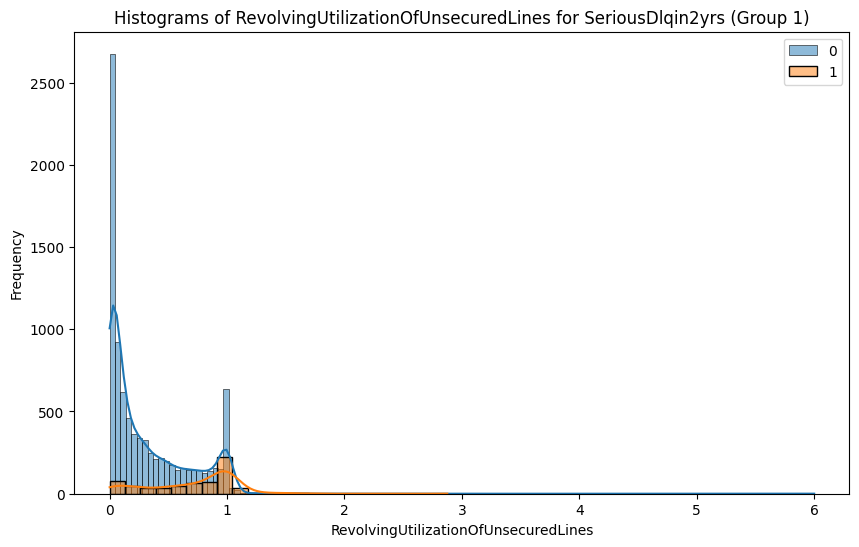

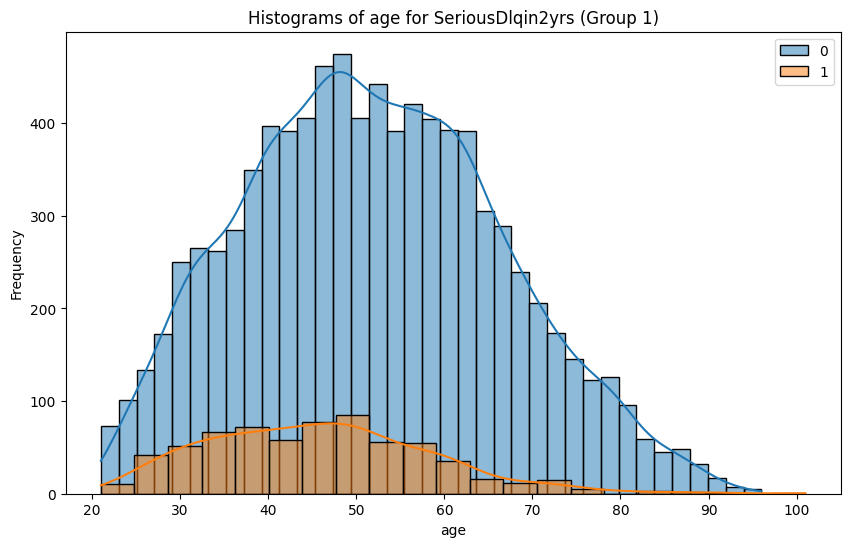

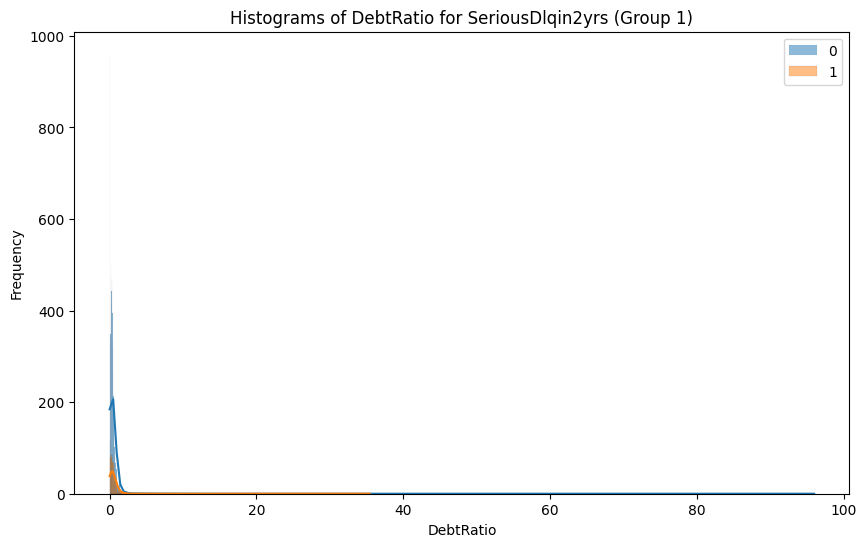

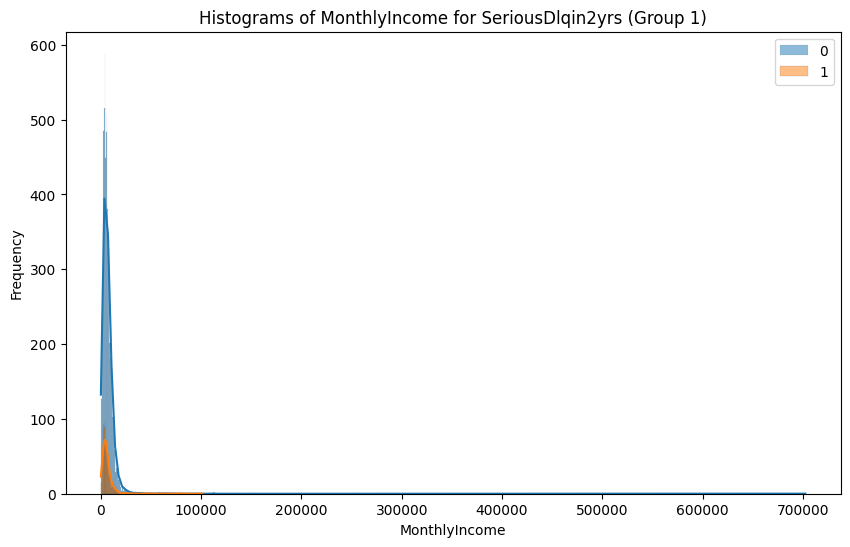

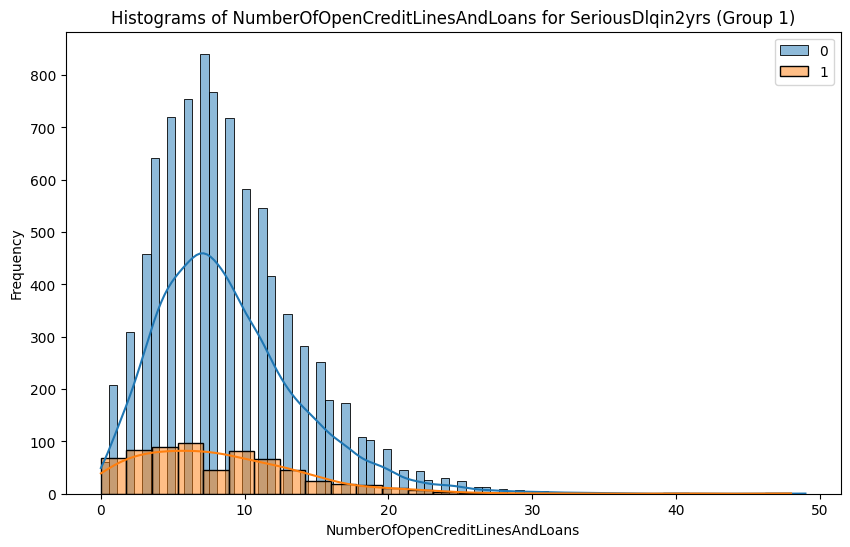

In [33]:
for columna_numerica in columnas_numericas:
    viz.plot_grouped_histograms(train_set, cat_col=target, num_col=columna_numerica, group_size=2)

Observando la distribución de los histogramas no se esperaría gran cosa de las variable numéricas. Mostramos las correlaciones con el *target*

In [34]:
train_set[columnas_numericas+[target]].corr()[[target]].abs().sort_values(by=target, ascending=False)

,SeriousDlqin2yrs
SeriousDlqin2yrs,1.000000
RevolvingUtilizationOfUnsecuredLines,0.284084
age,0.107801
NumberOfOpenCreditLinesAndLoans,0.032472
MonthlyIncome,0.018163
DebtRatio,0.001863


Las variables `RevolvingUtilizationOfUnsecuredLines` y `age` son las que mejor se posicionan. Realizamos el test para confirmar si hay relación con cierta significancia

In [35]:
valores_target = train_set[target].unique()
lista_p_value = []

for columna_numerica in columnas_numericas:
    
    numerica_por_target = [train_set.loc[train_set[target] == valor, columna_numerica] for valor in valores_target]
    f_val, p_val = stats.f_oneway(*numerica_por_target)
    lista_p_value.append(p_val)

df_pvalue = pd.DataFrame({"Variable_numerica": columnas_numericas, "p_value": lista_p_value}).sort_values(by="p_value", ascending=True)
df_pvalue

,Variable_numerica,p_value
0,RevolvingUtilizationOfUnsecuredLines,6.129144e-175
1,age,7.783159e-26
4,NumberOfOpenCreditLinesAndLoans,1.591652e-03
3,MonthlyIncome,7.744591e-02
2,DebtRatio,8.562979e-01


Aquí se vuelve a observar que `RevolvingUtilizationOfUnsecuredLines` y `age` son las variables cuya relación con el *target* tienen las mayores significancias estadísticas (con mucha diferencia respecto a la demás)

Nos quedamos con las variables `RevolvingUtilizationOfUnsecuredLines` y `age` como *features* numéricas

In [36]:
features_numericas_visual = ["RevolvingUtilizationOfUnsecuredLines", "age"]
features_numericas_visual

['RevolvingUtilizationOfUnsecuredLines', 'age']

### 2. Variables categóricas

Realizamos el análisis bivariante de las variables categóricas con el *target*

In [37]:
columnas_categoricas = [columna for columna in train_set if "_agrupado" in columna and columna != target]
columnas_categoricas

['NumberOfTime30-59DaysPastDueNotWorse_agrupado',
 'NumberOfTimes90DaysLate_agrupado',
 'NumberOfTime60-89DaysPastDueNotWorse_agrupado',
 'NumberRealEstateLoansOrLines_agrupado',
 'NumberOfDependents_agrupado']

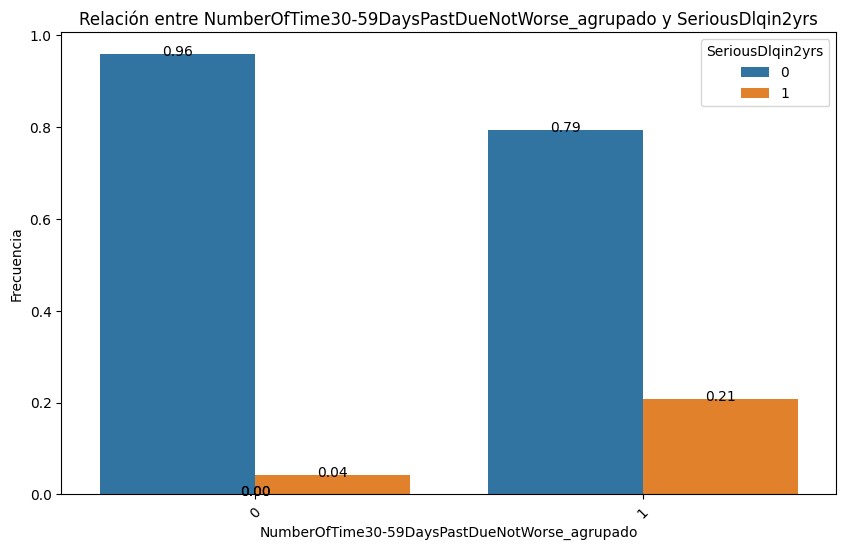

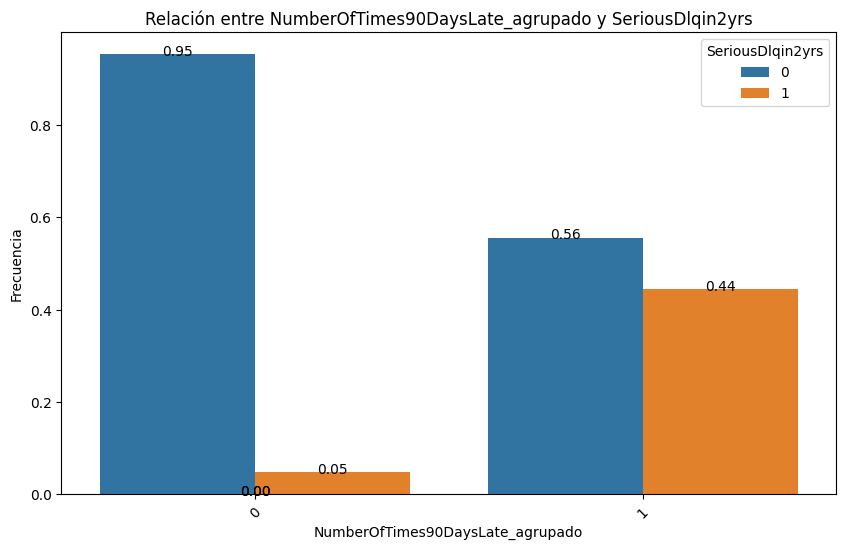

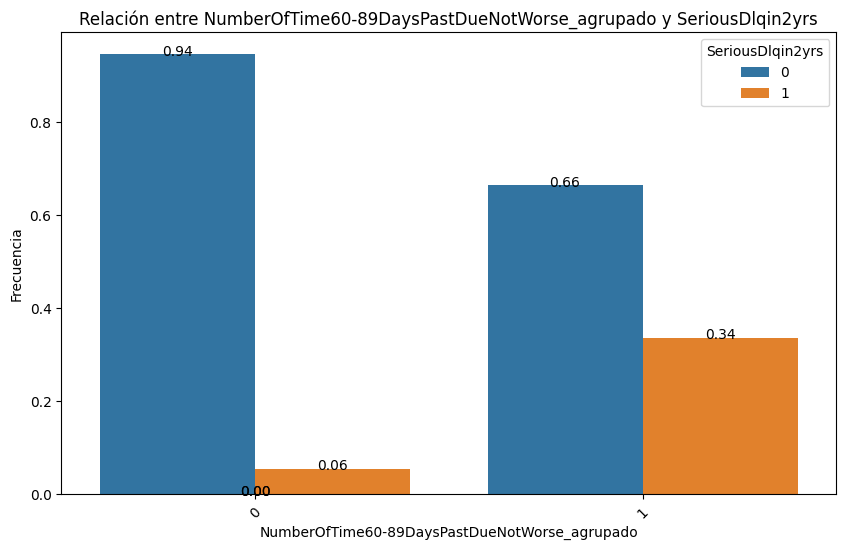

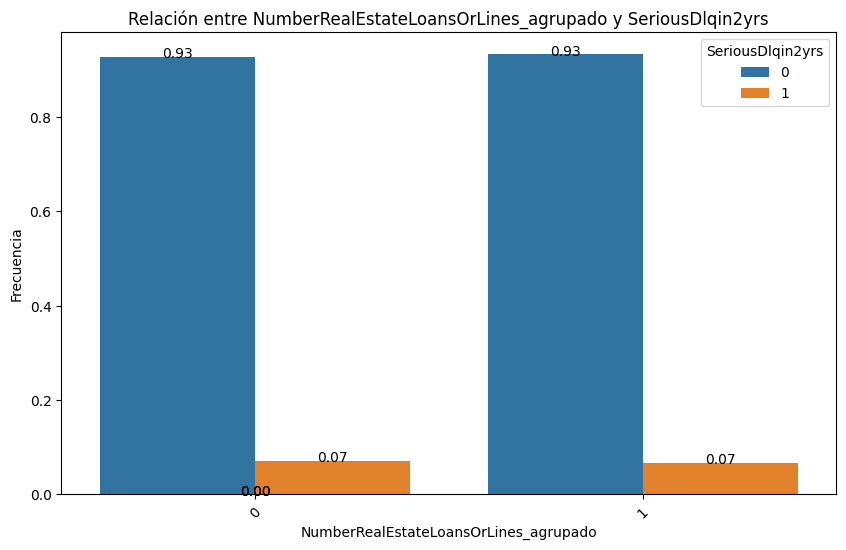

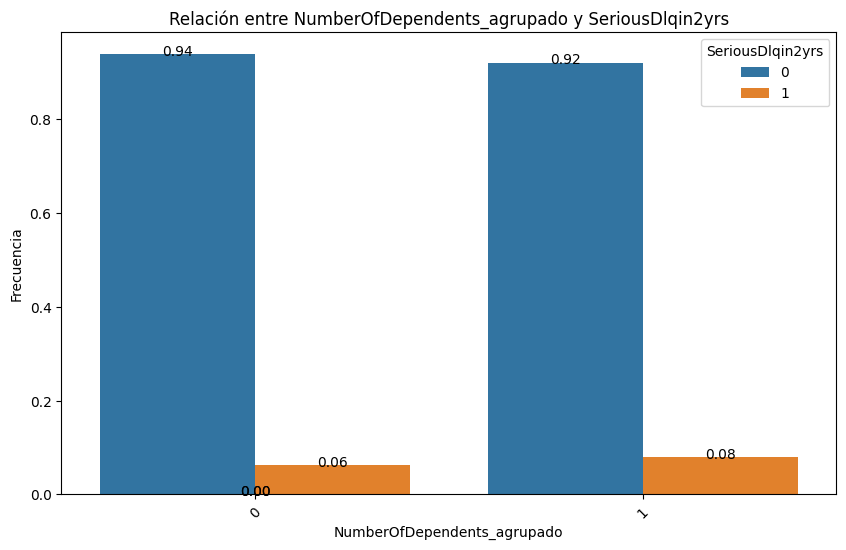

In [38]:
for columna_categoria in columnas_categoricas:
    viz.plot_categorical_relationship_fin(train_set, cat_col1=columna_categoria, cat_col2=target, relative_freq=True, show_values=True, size_group=2)

Las variables `NumberRealEstateLoansOrLines_agrupado` y `NumberOfDependents_agrupado` visualmente no presentan variación según cada valor del *target*. Realizamos el test para confirmar si hay relación con cierta significancia

In [39]:
lista_p_value = []

for columna_categoria in columnas_categoricas:
    
    tabla_contingencia = pd.crosstab(train_set[columna_categoria], train_set[target])

    chi2, p_val, dof, expected = stats.chi2_contingency(tabla_contingencia)
    lista_p_value.append(p_val)

df_pvalue = pd.DataFrame({"Variable_categorica": columnas_categoricas, "p_value": lista_p_value}).sort_values(by="p_value", ascending=True)
df_pvalue

,Variable_categorica,p_value
1,NumberOfTimes90DaysLate_agrupado,8.330304e-265
2,NumberOfTime60-89DaysPastDueNotWorse_agrupado,7.330589e-126
0,NumberOfTime30-59DaysPastDueNotWorse_agrupado,5.600312e-121
4,NumberOfDependents_agrupado,9.218088e-04
3,NumberRealEstateLoansOrLines_agrupado,4.656963e-01


Las variables `NumberOfDependents_agrupado` y `NumberRealEstateLoansOrLines_agrupado` son las que mayor pvalue tienen (relación con menor significancia estadística) con diferencia de las otras tres. Las decartamos y quedamos con el resto de variables como *features* categóricas

In [40]:
features_categoricas_visual = columnas_categoricas.copy()
categoria_eliminar = ["NumberRealEstateLoansOrLines_agrupado", "NumberOfDependents_agrupado",]

for columna in categoria_eliminar:
    features_categoricas_visual.remove(columna)

features_categoricas_visual

['NumberOfTime30-59DaysPastDueNotWorse_agrupado',
 'NumberOfTimes90DaysLate_agrupado',
 'NumberOfTime60-89DaysPastDueNotWorse_agrupado']

Guardamos la selección final de *features* obtenidas mediante análisis visual y filtrado 

In [41]:
features_1 = features_numericas_visual + features_categoricas_visual

Comprobamos que no exista correlación muy alta entre las *features* para evitar colinealidad en los datos

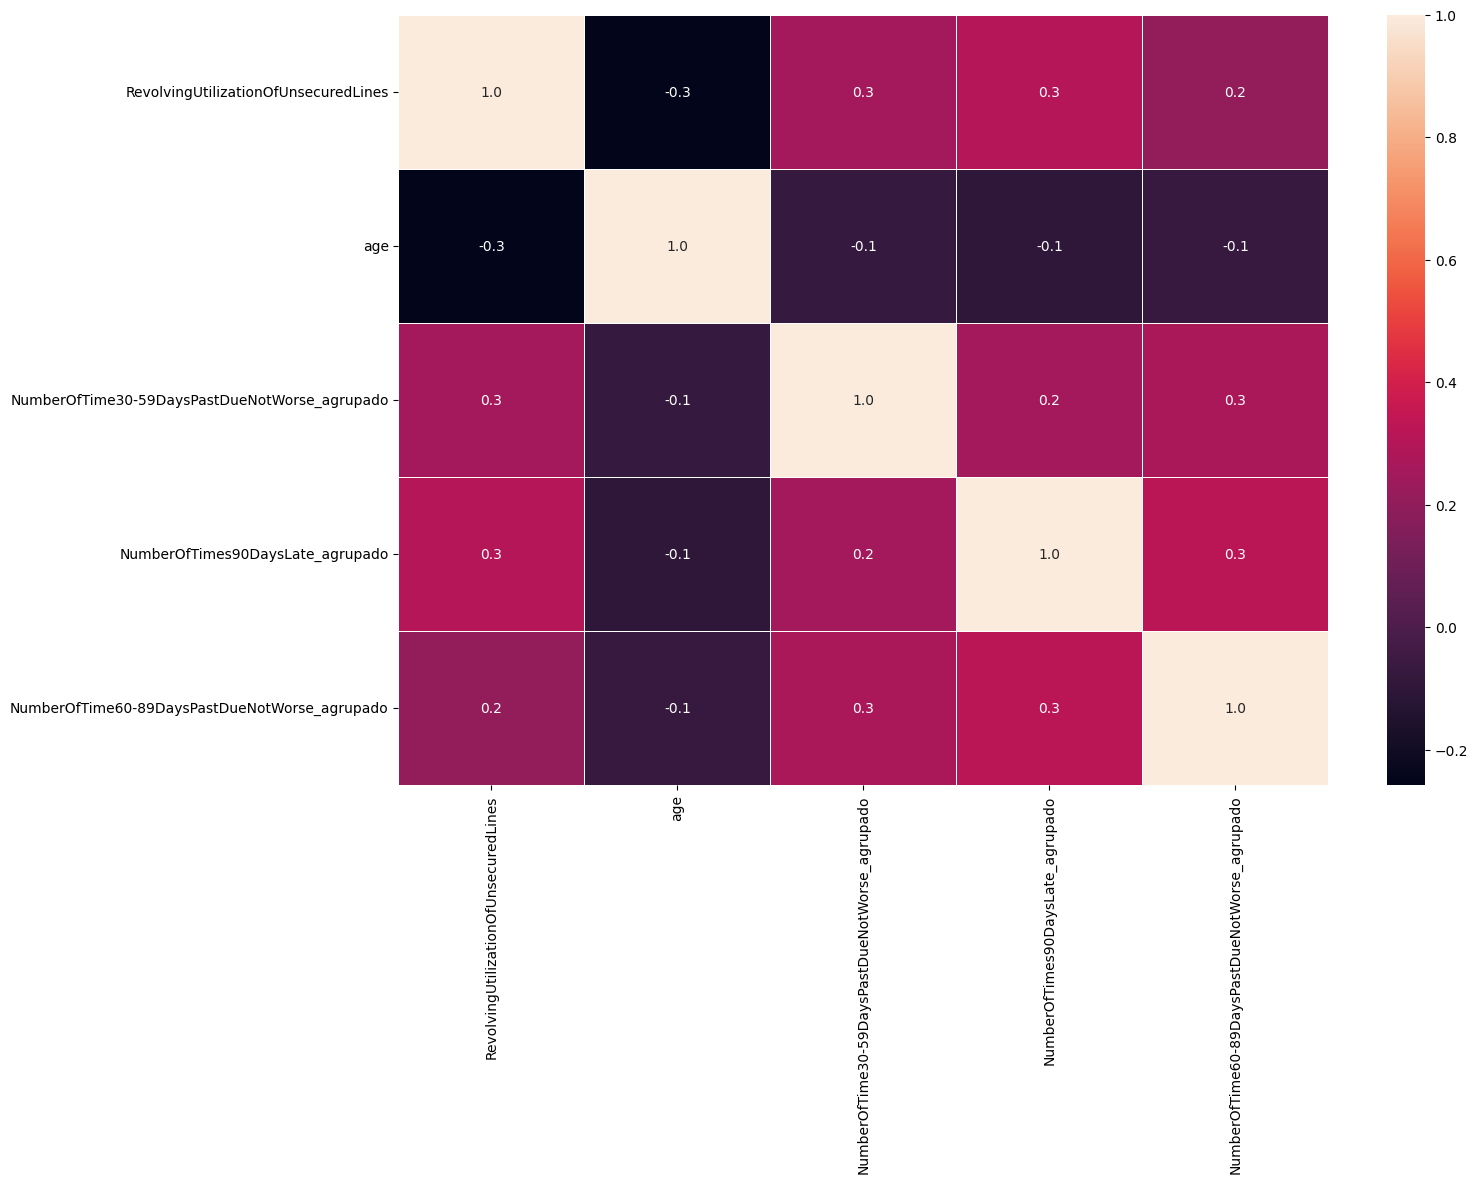

In [42]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_set[features_1].corr(numeric_only=True), annot=True, linewidths=.5, fmt= '.1f');

Se observa que las correlaciones entre *features* son bajas. Confirmamos una lista con cinco *features* mediante el análisis visual y filtrado

In [43]:
features_1

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse_agrupado',
 'NumberOfTimes90DaysLate_agrupado',
 'NumberOfTime60-89DaysPastDueNotWorse_agrupado']

### **2. Selección mediante SelectKBest y ANOVA y Mutual Information**

### 1. Variables numéricas

Empleamos SelectKBest y ANOVA para obtener las *features* numéricas. Tomamos k=2 ya que tenemos una orientación de ese valor del análisis visual previo

In [44]:
selector = SelectKBest(f_classif, k=2).fit(train_set[columnas_numericas], train_set[target])

best_features_sorted = pd.DataFrame({'Feature': train_set[columnas_numericas].columns, 'Score': selector.scores_}).sort_values(by='Score', ascending=False)
best_features_sorted.head()

,Feature,Score
0,RevolvingUtilizationOfUnsecuredLines,829.602605
1,age,111.110548
4,NumberOfOpenCreditLinesAndLoans,9.975168
3,MonthlyIncome,3.118382
2,DebtRatio,0.032795


Obtenemos igualmente que las dos mejores *features* numéricas son `RevolvingUtilizationOfUnsecuredLines` y `age`, como era de esperar, con diferencia respecto a las demás

In [45]:
features_numericas_kbest = selector.get_feature_names_out().tolist()
features_numericas_kbest

['RevolvingUtilizationOfUnsecuredLines', 'age']

### 2. Variables categóricas

Mostramos el Mutual Information de cada variable con el *target*

In [46]:
lista_mi = []
for columna_categoria in columnas_categoricas:

    mi = mutual_info_score(train_set[columna_categoria],train_set[target])
    lista_mi.append(mi)

df_mi = pd.DataFrame({"Variable_categorica": columnas_categoricas, "Mutual_Information": lista_mi}).sort_values(by="Mutual_Information", ascending=False)
df_mi

,Variable_categorica,Mutual_Information
1,NumberOfTimes90DaysLate_agrupado,0.034215
0,NumberOfTime30-59DaysPastDueNotWorse_agrupado,0.022123
2,NumberOfTime60-89DaysPastDueNotWorse_agrupado,0.017771
4,NumberOfDependents_agrupado,0.000593
3,NumberRealEstateLoansOrLines_agrupado,0.000032


Confirmamos que las variables `NumberOfDependents_agrupado` y `NumberRealEstateLoansOrLines_agrupado` son las que menor información mutua tienen con diferencia de las otras tres. Las descartamos y nos quedamos con las tres primeras

In [47]:
features_categoricas_mi = features_categoricas_visual.copy()
features_categoricas_mi

['NumberOfTime30-59DaysPastDueNotWorse_agrupado',
 'NumberOfTimes90DaysLate_agrupado',
 'NumberOfTime60-89DaysPastDueNotWorse_agrupado']

Guardamos las *features* en una variable

In [48]:
features_2 = features_numericas_kbest + features_categoricas_mi
features_2

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse_agrupado',
 'NumberOfTimes90DaysLate_agrupado',
 'NumberOfTime60-89DaysPastDueNotWorse_agrupado']

### **3. Selección mediante un modelo intermedio**

Creamos los DataFrames X e y de train

In [49]:
X_train = train_set.drop(columns=[target]).copy()
y_train = train_set[target].copy()

Instanciamos un modelo RandomForest, ya que tiene la ventaja de no necesitar escalado de *features*, y usamos SelectFromModel con el hiperparámetro `threshold="median"` para la selección de *features*

In [50]:
rf = RandomForestClassifier(max_depth=5, random_state = 42)

selector_model = SelectFromModel(estimator=rf, threshold="median")
selector_model.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(max_depth=5, random_state=42),
                threshold='median')

In [51]:
selector_model.get_feature_names_out()

array(['RevolvingUtilizationOfUnsecuredLines',
       'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTime30-59DaysPastDueNotWorse_agrupado',
       'NumberOfTimes90DaysLate_agrupado',
       'NumberOfTime60-89DaysPastDueNotWorse_agrupado'], dtype=object)

Guardamos las *features* en una variable

In [52]:
features_3 = selector_model.get_feature_names_out().tolist()
features_3

['RevolvingUtilizationOfUnsecuredLines',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTime30-59DaysPastDueNotWorse_agrupado',
 'NumberOfTimes90DaysLate_agrupado',
 'NumberOfTime60-89DaysPastDueNotWorse_agrupado']

### **4. Selección mediante RFE (Recursive Feature Elimination)**

Tomamos n_features_to_select=5 ya que tenemos una orientación de este valor de los apartados anteriores

In [53]:
rfe = RFE(estimator = rf, n_features_to_select= 5, step = 1)
rfe.fit(X_train, y_train)

pd.DataFrame(data=rfe.ranking_, columns= ["ranking"], index = X_train.columns).sort_values("ranking")

,ranking
RevolvingUtilizationOfUnsecuredLines,1
DebtRatio,1
NumberOfTime30-59DaysPastDueNotWorse_agrupado,1
NumberOfTimes90DaysLate_agrupado,1
NumberOfTime60-89DaysPastDueNotWorse_agrupado,1
NumberOfOpenCreditLinesAndLoans,2
age,3
MonthlyIncome,4
NumberRealEstateLoansOrLines_agrupado,5
NumberOfDependents_agrupado,6


Guardamos las *features* en una variable

In [54]:
features_4 = rfe.get_feature_names_out().tolist()
features_4

['RevolvingUtilizationOfUnsecuredLines',
 'DebtRatio',
 'NumberOfTime30-59DaysPastDueNotWorse_agrupado',
 'NumberOfTimes90DaysLate_agrupado',
 'NumberOfTime60-89DaysPastDueNotWorse_agrupado']

### **5. Selección mediante SFS (Sequential Feature Selector)**

Tomamos n_features_to_select=5 ya que tenemos una orientación de este valor de los apartados anteriores

In [55]:
sfs = SequentialFeatureSelector(rf, n_features_to_select = 5, cv = 5, scoring = "balanced_accuracy")
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=RandomForestClassifier(max_depth=5,
                                                           random_state=42),
                          n_features_to_select=5, scoring='balanced_accuracy')

In [56]:
sfs.get_feature_names_out()

array(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse_agrupado',
       'NumberOfTimes90DaysLate_agrupado',
       'NumberRealEstateLoansOrLines_agrupado'], dtype=object)

Guardamos las *features* en una variable

In [57]:
features_5 = sfs.get_feature_names_out().tolist()
features_5

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse_agrupado',
 'NumberOfTimes90DaysLate_agrupado',
 'NumberRealEstateLoansOrLines_agrupado']

### **6. Selección mediante *hard-voting***

In [58]:
lista_votos = []

for feature in X_train.columns:
    
    votos = 0
    if feature in features_1:
        votos += 1
    if feature in features_2:
        votos += 1
    if feature in features_3:
        votos += 1
    if feature in features_4:
        votos += 1
    if feature in features_5:
        votos += 1
    
    lista_votos.append(votos) 

df_votos = pd.DataFrame({"Features": X_train.columns, "Votos": lista_votos}).sort_values(by="Votos", ascending=False)
df_votos

,Features,Votos
0,RevolvingUtilizationOfUnsecuredLines,5
5,NumberOfTime30-59DaysPastDueNotWorse_agrupado,5
6,NumberOfTimes90DaysLate_agrupado,5
7,NumberOfTime60-89DaysPastDueNotWorse_agrupado,4
1,age,3
2,DebtRatio,1
4,NumberOfOpenCreditLinesAndLoans,1
8,NumberRealEstateLoansOrLines_agrupado,1
3,MonthlyIncome,0
9,NumberOfDependents_agrupado,0


Guardamos la primeras cinco *features* con mayor número de votos en una variable

In [59]:
features_6 = df_votos["Features"].head(5).tolist()
features_6

['RevolvingUtilizationOfUnsecuredLines',
 'NumberOfTime30-59DaysPastDueNotWorse_agrupado',
 'NumberOfTimes90DaysLate_agrupado',
 'NumberOfTime60-89DaysPastDueNotWorse_agrupado',
 'age']

## **Comparación de modelos**

Usaremos los modelos RandomForest, XGBoost y LightGBM

In [61]:
rf_clf = RandomForestClassifier(max_depth= 5, random_state= 42)
xgb_clf = XGBClassifier(max_depth = 5, random_state = 42)
lgb_clf = LGBMClassifier(max_depth= 5, random_state = 42, verbose = -100)

modelos = {
    "Random Forest": rf_clf,
    "XGBoost": xgb_clf,
    "Lightgbm": lgb_clf,
}

Entrenamos los 3 modelos para cada set de *features* y evaluamos con validación cruzada

In [62]:
features_dict = {
    "Set apartado_1": features_1,
    "Set apartado_2": features_2,
    "Set apartado_3": features_3,
    "Set apartado_4": features_4,
    "Set apartado_5": features_5,
    "Set apartado_6": features_6,  
}

for apartado, features in features_dict.items():
    
    print(f"Para {apartado}: {features}\n")
    X_train = train_set[features].copy()
    
    for nombre_modelo, modelo in modelos.items():
        
        print(f"{nombre_modelo}: ", end = " ")
        score = round(np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy")), 3)
        print(score)

    print("\n*****************\n")

Para Set apartado_1: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse_agrupado', 'NumberOfTimes90DaysLate_agrupado', 'NumberOfTime60-89DaysPastDueNotWorse_agrupado']

Random Forest:  0.562
XGBoost:  0.577
Lightgbm:  0.582

*****************

Para Set apartado_2: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse_agrupado', 'NumberOfTimes90DaysLate_agrupado', 'NumberOfTime60-89DaysPastDueNotWorse_agrupado']

Random Forest:  0.562
XGBoost:  0.577
Lightgbm:  0.582

*****************

Para Set apartado_3: ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTime30-59DaysPastDueNotWorse_agrupado', 'NumberOfTimes90DaysLate_agrupado', 'NumberOfTime60-89DaysPastDueNotWorse_agrupado']

Random Forest:  0.562
XGBoost:  0.584
Lightgbm:  0.585

*****************

Para Set apartado_4: ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'NumberOfTime30-59DaysPastDueNotWorse_agrupado', 'NumberOfTi

Obtenemos que la mejor selección de *features* es la del apartado 5 ya que obtenemos el mejor *score* (0.587) y lo hacemos con el modelo LightGBM

In [63]:
features_final = features_5
features_final

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse_agrupado',
 'NumberOfTimes90DaysLate_agrupado',
 'NumberRealEstateLoansOrLines_agrupado']

### **Optimización de hiperparámetros y evaluación contra test**

In [64]:
X_train_final = train_set[features_final].copy()
y_train_final = train_set[target].copy()

X_test_final = test_set[features_final].copy()
y_test_final = test_set[target].copy()

In [65]:
lgbm_optimizar = LGBMClassifier(random_state = 42, verbose = -100)

grid_lgbm = {
    'class_weight': ["balanced", None],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'colsample_bytree': [0.8, 1.0]
}

lgbm_grid = GridSearchCV(lgbm_optimizar, param_grid= grid_lgbm, cv=5, scoring= "balanced_accuracy", n_jobs=-1)

lgbm_grid.fit(X_train_final, y_train_final)

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42, verbose=-100),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.1, 0.01],
                         'max_depth': [5, 10, None],
                         'n_estimators': [100, 200]},
             scoring='balanced_accuracy')

In [66]:
lgbm_grid.best_params_

{'class_weight': 'balanced',
 'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 100}

Evaluamos el modelo con los mejores hiperparámetros contra test

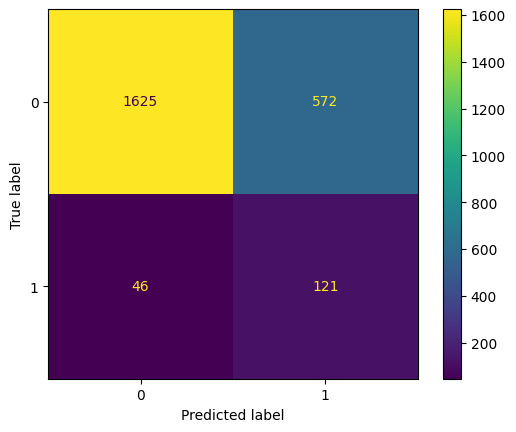

In [67]:
y_pred = lgbm_grid.best_estimator_.predict(X_test_final)
ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred);

In [68]:
report = classification_report(y_test_final, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      2197
           1       0.17      0.72      0.28       167

    accuracy                           0.74      2364
   macro avg       0.57      0.73      0.56      2364
weighted avg       0.92      0.74      0.80      2364



Conseguimos optimizar el *recall* medio de un 59% a un 73%, pero a costa del *precision* de la clase 1 que sale muy bajo (un 17%). Básicamente, para asegurar el *recall* de la clase 1 estamos etiquetando muchas instancias como clase 1 que realmente no lo son

### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.